In [1]:
import numpy as np
import sys
sys.path.append('/Users/diegofiori/Desktop/epfl/master_thesis/master_thesis/')
from utils import read_pickle
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
FILE_PATH = '/Users/diegofiori/Desktop/epfl/master_thesis/results/'
sim_code = 'cs'

In [3]:
physics_ = read_pickle(FILE_PATH+f'physical_features_{sim_code}.pickle')

In [4]:
physics_ = np.concatenate([physics_[i] for i in range(len(physics_))])

In [5]:
physics_.shape

(1888,)

In [6]:
density = np.exp(physics_)

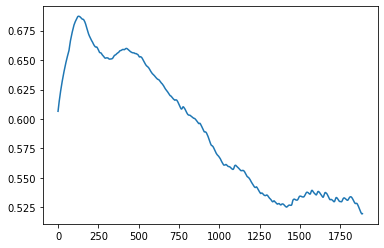

In [7]:
plt.plot(density)

# Phase Space Analysis

In [10]:
top_feature_phase_space = read_pickle(FILE_PATH + f'phase_space_top_features_{sim_code}.pickle')

In [11]:
top_feature_phase_space.shape

(63, 11)

In [8]:
def compute_signal_processing_correlation(matrix_ts, target_ts):
    correlations = []
    for i in range(matrix_ts.shape[1]):
        correlations.append(np.correlate(matrix_ts[:, i], target_ts, 'same').reshape((-1, 1)))
        
    return np.concatenate(correlations, axis=1)

In [13]:
correlation_topo_matrix = compute_signal_processing_correlation(top_feature_phase_space, density.values)

In [14]:
best_positive_correlated_feat_idx = correlation_topo_matrix.max(axis=0).argmax()
best_positive_correlated_feat = correlation_topo_matrix[:, best_positive_correlated_feat_idx]
best_negative_correlated_feat_idx = correlation_topo_matrix.min(axis=0).argmin()
best_negative_correlated_feat = correlation_topo_matrix[:, best_negative_correlated_feat_idx]

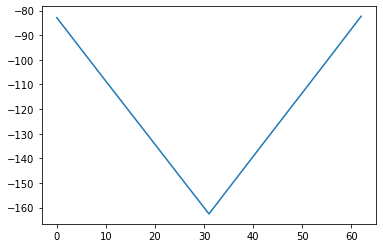

In [15]:
plt.plot(best_negative_correlated_feat)

# Images Analysis

In [9]:
images_complexes = read_pickle(FILE_PATH + f'slices_top_features_{sim_code}.pickle')

In [10]:
selected_index = read_pickle(FILE_PATH + f'selected_index_{sim_code}.pickle')

In [11]:
selected_index

[(2, 29, 0),
 (2, 31, 33),
 (2, 17, 32),
 (2, 71, 32),
 (1, 4, 18),
 (2, 68, 32),
 (1, 76, 31),
 (2, 37, 32),
 (2, 15, 31),
 (2, 8, 33),
 (1, 27, 33),
 (2, 75, 32),
 (0, 51, 1),
 (1, 53, 16),
 (1, 42, 28),
 (1, 44, 11),
 (1, 15, 1),
 (1, 65, 19),
 (1, 26, 16),
 (1, 36, 29),
 (1, 64, 24),
 (1, 13, 28),
 (2, 1, 32),
 (0, 68, 33),
 (1, 56, 28),
 (2, 64, 32),
 (1, 15, 28),
 (2, 42, 32),
 (2, 62, 33),
 (0, 28, 29),
 (0, 62, 29),
 (0, 44, 32),
 (2, 78, 33),
 (1, 13, 23),
 (1, 42, 29),
 (1, 39, 28),
 (2, 60, 32),
 (2, 26, 32),
 (2, 68, 29),
 (0, 79, 28),
 (2, 70, 29),
 (2, 66, 32),
 (1, 18, 28),
 (0, 69, 29),
 (2, 50, 29),
 (2, 67, 29),
 (0, 75, 29),
 (1, 49, 29),
 (0, 14, 29),
 (0, 7, 32),
 (0, 69, 32),
 (1, 22, 28),
 (1, 8, 28),
 (1, 69, 29),
 (2, 45, 29),
 (0, 18, 29),
 (0, 29, 29),
 (1, 52, 28),
 (0, 39, 29),
 (0, 68, 29),
 (2, 58, 33),
 (1, 68, 28),
 (1, 62, 28),
 (2, 53, 32),
 (1, 43, 28),
 (1, 21, 28),
 (1, 4, 29),
 (1, 43, 32),
 (0, 5, 29),
 (1, 73, 29),
 (1, 50, 28),
 (0, 59, 29),
 (

In [12]:
images_complexes.shape

(3, 150720, 34)

In [13]:
images_complexes = np.concatenate([np.expand_dims(images_complexes[:, i:i+80], axis=1) 
                                   for i in range(0, images_complexes.shape[1], 80)], axis=1)





In [15]:
images_complexes.shape

(3, 1884, 80, 34)

In [23]:
density = density[:images_complexes.shape[1]]

In [16]:
def compute_signal_processing_correlation(feature_ts, target_ts):
    return np.correlate(feature_ts, target_ts, 'same')

In [24]:
correlations_series = []
for i in range(images_complexes.shape[0]):
    for j in range(images_complexes.shape[2]):
        for k in range(images_complexes.shape[3]):
            if (i, j, k) in selected_index:
                series = pd.Series(data=compute_signal_processing_correlation(images_complexes[i, :, j, k], density),
                                   name=(i, j, k))
                correlations_series.append(series)

In [25]:
matrix_corr_images = pd.concat(correlations_series, axis=1)

In [26]:
matrix_corr_images.shape

(1884, 510)

In [27]:
images_complexes[0, :, 0, :].shape

(1884, 34)

In [29]:
matrix_corr_images = matrix_corr_images.loc[:, ~np.isnan(matrix_corr_images.sum(axis=0))]

In [31]:
best_positive_correlated_img_idx = matrix_corr_images.max(axis=0).argmax()
best_positive_correlated_img = matrix_corr_images.loc[:, best_positive_correlated_img_idx]
best_negative_correlated_img_idx = matrix_corr_images.min(axis=0).argmin()
best_negative_correlated_img = matrix_corr_images.loc[:, best_negative_correlated_img_idx]

/Users/diegofiori/anaconda3/envs/giotto_env/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  """Entry point for launching an IPython kernel.
/Users/diegofiori/anaconda3/envs/giotto_env/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


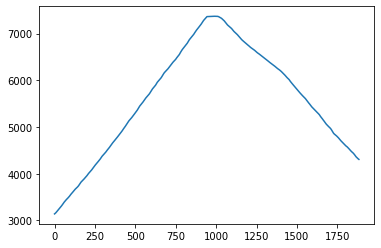

In [32]:
plt.plot(best_positive_correlated_img)

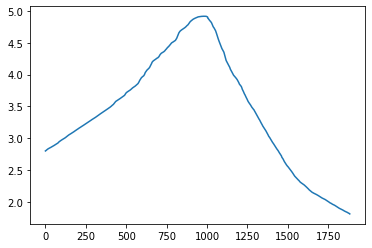

In [33]:
plt.plot(best_negative_correlated_img)

# Pearson Correlation

In [34]:
from scipy.stats import pearsonr
import pandas as pd

In [35]:
def compute_pearson_cross_correlation(x, y, tau_max):
    correlations = pd.Series(data=np.zeros((2*tau_max + 1)), index=np.arange(-tau_max, tau_max + 1))
    for i in range(-tau_max, tau_max + 1):
        if i > 0:
            new_x = x[:-i]
            new_y = y[i:]
        if i < 0:
            new_x = x[-i:]
            new_y = y[:i]
        else: 
            new_x = x
            new_y = y
        correlations[i] = pearsonr(new_x, new_y)[0]
    return correlations

In [36]:
new_density = density

In [37]:
max_shift = 10
a = images_complexes[0, :, 0, 0]
compute_pearson_cross_correlation(a, new_density, max_shift)

-10   -0.150242
-9    -0.152520
-8    -0.154671
-7    -0.156805
-6    -0.158859
-5    -0.160837
-4    -0.162775
-3    -0.164689
-2    -0.164027
-1    -0.165812
 0    -0.167647
 1    -0.167647
 2    -0.167647
 3    -0.167647
 4    -0.167647
 5    -0.167647
 6    -0.167647
 7    -0.167647
 8    -0.167647
 9    -0.167647
 10   -0.167647
dtype: float64

In [39]:
max_shift = 20
correlations = []
for i in range(images_complexes.shape[0]):
    for j in range(images_complexes.shape[2]):
        for k in range(images_complexes.shape[3]):
            if (i, j, k) in selected_index:
                temp = images_complexes[i, :, j, k]
                if np.isnan(temp.sum()):
                    temp = np.nan_to_num(temp)
                corr = compute_pearson_cross_correlation(temp, new_density, max_shift)
                corr.name = (i, j, k)
                correlations.append(corr)
correlation_df = pd.concat(correlations, axis=1)

In [40]:
mcidx = correlation_df.max().argmax()

/Users/diegofiori/anaconda3/envs/giotto_env/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  """Entry point for launching an IPython kernel.


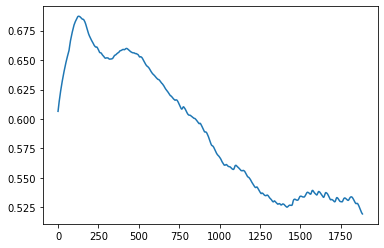

In [41]:
plt.figure()
plt.plot(new_density)

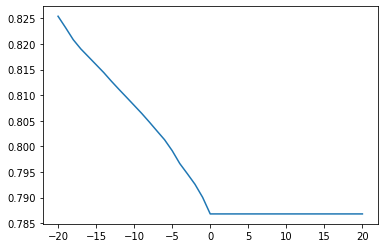

In [42]:
plt.figure()
plt.plot(correlation_df[mcidx])

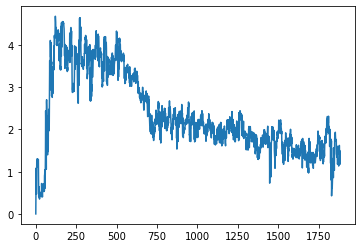

In [43]:
most_correlated = images_complexes[mcidx[0], :, mcidx[1], mcidx[2]]
plt.figure()
plt.plot(most_correlated)

/Users/diegofiori/anaconda3/envs/giotto_env/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  """Entry point for launching an IPython kernel.


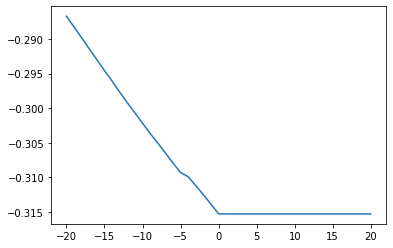

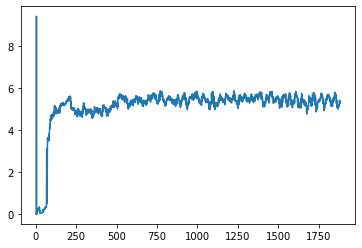

In [44]:
lcidx = correlation_df.min().argmin()
less_correlated = images_complexes[lcidx[0], :, lcidx[1], lcidx[2]]
plt.figure()
plt.plot(correlation_df[lcidx])
plt.figure()
plt.plot(less_correlated)

Now we consider only future correlation

In [45]:
def compute_pearson_future_cross_correlation(x, y, tau_max):
    correlations = pd.Series(data=np.zeros(tau_max + 1), index=np.arange(tau_max + 1))
    for i in range(tau_max + 1):
        if i > 0:
            new_x = x[:-i]
            new_y = y[i:]
        else: 
            new_x = x
            new_y = y
        correlations[i] = pearsonr(new_x, new_y)[0]
    return correlations

In [46]:
max_shift = 20
fut_correlations = []
for i in range(images_complexes.shape[0]):
    for j in range(images_complexes.shape[2]):
        for k in range(images_complexes.shape[3]):
            if (i, j, k) in selected_index:
                temp = images_complexes[i, :, j, k]
                if np.isnan(temp.sum()):
                    temp = np.nan_to_num(temp)
                corr = compute_pearson_future_cross_correlation(temp, new_density, max_shift)
                corr.name = (i, j, k)
                fut_correlations.append(corr)
fut_correlation_df = pd.concat(fut_correlations, axis=1)

/Users/diegofiori/anaconda3/envs/giotto_env/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  """Entry point for launching an IPython kernel.


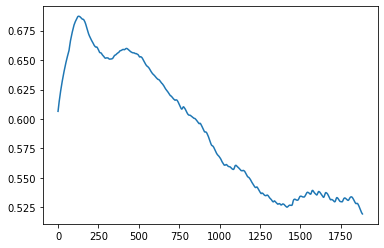

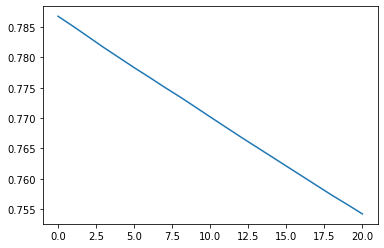

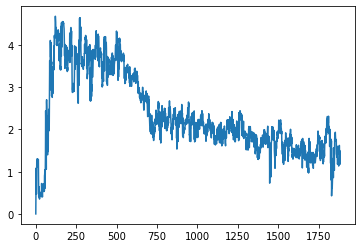

In [47]:
mcidx = fut_correlation_df.max().argmax()

plt.figure()
plt.plot(new_density)

plt.figure()
plt.plot(fut_correlation_df[mcidx])

most_correlated = images_complexes[mcidx[0], :, mcidx[1], mcidx[2]]
plt.figure()
plt.plot(most_correlated)

/Users/diegofiori/anaconda3/envs/giotto_env/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  """Entry point for launching an IPython kernel.


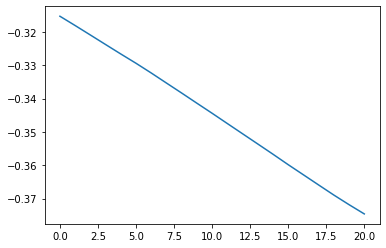

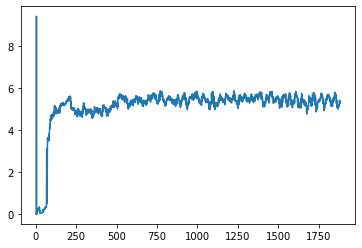

In [48]:
lcidx = fut_correlation_df.min().argmin()
less_correlated = images_complexes[lcidx[0], :, lcidx[1], lcidx[2]]
plt.figure()
plt.plot(fut_correlation_df[lcidx])
plt.figure()
plt.plot(less_correlated)

Looking for spikes

/Users/diegofiori/anaconda3/envs/giotto_env/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  


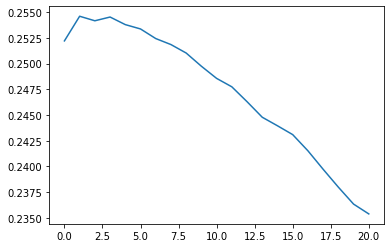

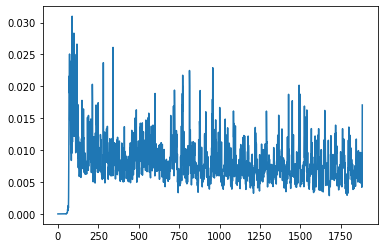

In [49]:
correlation_derivatives_df = fut_correlation_df.diff().dropna()
max_cdidx = correlation_derivatives_df.max().argmax()
plt.figure()
plt.plot(fut_correlation_df[max_cdidx])
plt.figure()
plt.plot(images_complexes[max_cdidx[0], :, max_cdidx[1], max_cdidx[2]])

# Spearman correlation

In [50]:
from scipy.stats import spearmanr

In [51]:
def compute_spearman_future_cross_correlation(x, y, tau_max):
    correlations = pd.Series(data=np.zeros(tau_max + 1), index=np.arange(tau_max + 1))
    for i in range(tau_max + 1):
        if i > 0:
            new_x = x[:-i]
            new_y = y[i:]
        else: 
            new_x = x
            new_y = y
        correlations[i] = spearmanr(new_x, new_y)[0]
    return correlations

In [52]:
max_shift = 20
correlations = []
for i in range(images_complexes.shape[0]):
    for j in range(images_complexes.shape[2]):
        for k in range(images_complexes.shape[3]):
            if (i, j, k) in selected_index:
                temp = images_complexes[i, :, j, k]
                if np.isnan(temp.sum()):
                    temp = np.nan_to_num(temp)
                corr = compute_spearman_future_cross_correlation(temp, new_density, max_shift)
                corr.name = (i, j, k)
                correlations.append(corr)
correlation_df = pd.concat(correlations, axis=1)

/Users/diegofiori/anaconda3/envs/giotto_env/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  """Entry point for launching an IPython kernel.


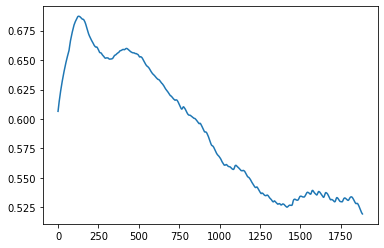

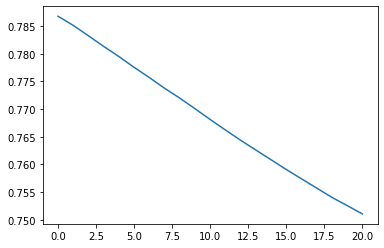

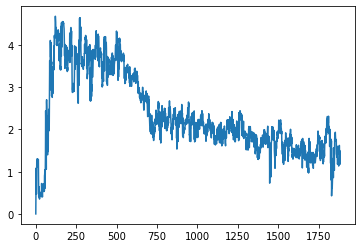

In [53]:
mcidx = correlation_df.max().argmax()

plt.figure()
plt.plot(new_density)

plt.figure()
plt.plot(correlation_df[mcidx])

most_correlated = images_complexes[mcidx[0], :, mcidx[1], mcidx[2]]
plt.figure()
plt.plot(most_correlated)

/Users/diegofiori/anaconda3/envs/giotto_env/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  """Entry point for launching an IPython kernel.


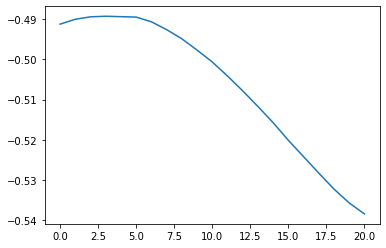

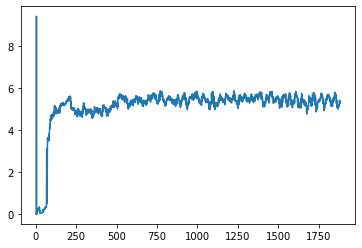

In [54]:
lcidx = correlation_df.min().argmin()
less_correlated = images_complexes[lcidx[0], :, lcidx[1], lcidx[2]]
plt.figure()
plt.plot(correlation_df[lcidx])
plt.figure()
plt.plot(less_correlated)

# Plot for the meeting with Paolo

Text(0, 0.5, 'top_feat')

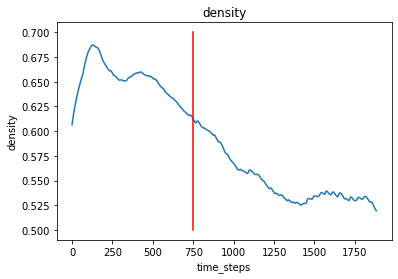

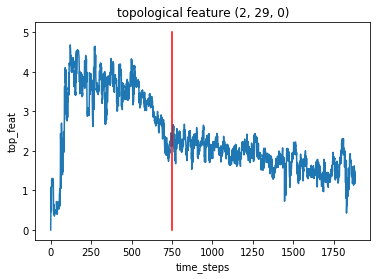

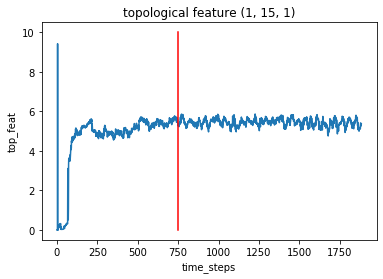

In [55]:
plt.figure()
plt.plot(density)
plt.plot([750, 750], [0.5, 0.7], 'r')
plt.title('density')
plt.xlabel('time_steps')
plt.ylabel('density')
plt.figure()
plt.plot(most_correlated)
plt.plot([750, 750], [0, 5], 'r')
plt.title(f'topological feature {mcidx}')
plt.xlabel('time_steps')
plt.ylabel('top_feat')
plt.figure()
plt.plot(less_correlated)
plt.plot([750, 750], [0, 10], 'r')
plt.title(f'topological feature {lcidx}')
plt.xlabel('time_steps')
plt.ylabel('top_feat')

## New data

In [61]:
new_sim_code = 'lem'
new_density = read_pickle(FILE_PATH+f'physical_features_{new_sim_code}.pickle')
new_density = np.concatenate([new_density[i] for i in range(len(new_density))])

In [62]:
new_density.shape

(290,)

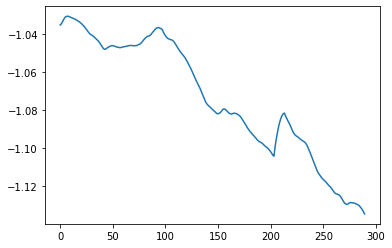

In [63]:
plt.plot(new_density)

In [64]:
new_slices = read_pickle(FILE_PATH + f'slices_top_features_{new_sim_code}.pickle')

In [65]:
new_slices.shape

(3, 23040, 34)

In [66]:
new_slices = np.concatenate([np.expand_dims(new_slices[:, i:i+80], axis=1) 
                             for i in range(0, new_slices.shape[1], 80)], axis=1)

In [67]:
new_slices.shape

(3, 288, 80, 34)

In [70]:
new_density = new_density[:new_slices.shape[1]]
new_most_correlated = new_slices[mcidx[0], :, mcidx[1], mcidx[2]]
new_less_correlated = new_slices[lcidx[0], :, lcidx[1], lcidx[2]]

Text(0, 0.5, 'top_feat')

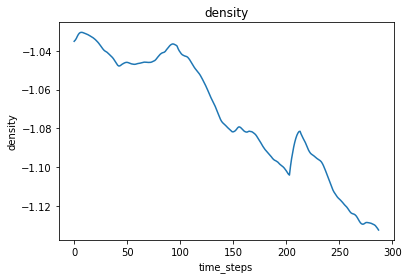

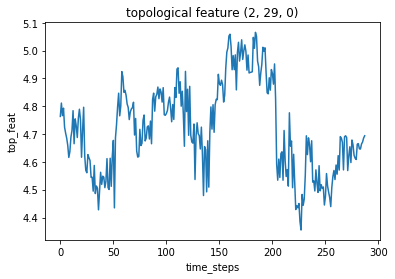

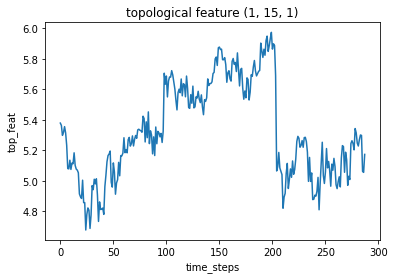

In [72]:
plt.figure()
plt.plot(new_density)
# plt.plot([750, 750], [0.5, 0.7], 'r')
plt.title('density')
plt.xlabel('time_steps')
plt.ylabel('density')
plt.figure()
plt.plot(new_most_correlated)
# plt.plot([750, 750], [0, 5], 'r')
plt.title(f'topological feature {mcidx}')
plt.xlabel('time_steps')
plt.ylabel('top_feat')
plt.figure()
plt.plot(new_less_correlated)
# plt.plot([750, 750], [0, 10], 'r')
plt.title(f'topological feature {lcidx}')
plt.xlabel('time_steps')
plt.ylabel('top_feat')